In [1]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style = 'white', color_codes = True)
%matplotlib inline

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples')])

import torch

from befit.agents import RLSocInf, HGFSocInf, SGFSocInf
from befit.inference import Horseshoe

In [2]:
blocks = 1  # number of experimental blocks

responses = torch.from_numpy(np.load('follow.npy')).float().unsqueeze(0)
nsub = responses.shape[-1]//2  # number of subjects
trials = responses.shape[1]  # number of trials

masks = (~torch.isnan(responses)).float()

offers = torch.from_numpy(np.load('offers.npy')).reshape(trials, -1, 1).repeat(1, 1, nsub)\
            .reshape(trials, -1).unsqueeze(0)

reliability = torch.from_numpy(2.*np.load('advice_reliability.npy')-1.).float()
reliability = reliability.reshape(trials, -1, 1).repeat(1, 1, nsub).reshape(trials, -1).unsqueeze(0)

stimuli = {'offers': offers, 
           'outcomes': reliability,
           'masks': masks}

formated_stimuli = []
for b in range(blocks):
    for t in range(trials):
        stimulus = {}
        for name in stimuli.keys():
            stimulus[name] = stimuli[name][b, t]
        formated_stimuli.append(stimulus)
        
stimuli = np.array(formated_stimuli).reshape(blocks, trials)
evidence = torch.zeros(3, 2*nsub)
n_samples = 1000

In [3]:
# RL agent
rl_agent = RLSocInf(runs=2*nsub, trials=trials)
rl_agent.set_parameters()
rl_infer = Horseshoe(rl_agent, stimuli, responses, mask=masks.byte())
rl_infer.infer_posterior(iter_steps=500)
rl_par_names = ['alpha', 'zeta', 'beta', 'bias']
rl_df = rl_infer.formated_results(rl_par_names)
sample_rl = rl_infer.sample_posterior(rl_par_names, n_samples=n_samples)
evidence[0] = rl_infer.get_log_evidence_per_subject()

Mean ELBO 7461.20: 100%|██████████| 500/500 [07:03<00:00,  1.21it/s]


In [4]:
#HGF agent
hgf_agent = HGFSocInf(runs=2*nsub, trials=trials)
hgf_agent.set_parameters()
hgf_infer = Horseshoe(hgf_agent, stimuli, responses, mask=masks.byte())
hgf_infer.infer_posterior(iter_steps=500)
hgf_par_names = ['mu0', 'eta', 'zeta', 'beta', 'bias']
labels = ['mu0_1', 'mu0_2', 'eta', 'zeta', 'beta', 'bias']
hgf_df = hgf_infer.formated_results(hgf_par_names, labels=labels)
hgf_df = hgf_df.loc[~(hgf_df['parameter']=='mu0_1')]
labels = ['mu0_2', 'eta', 'zeta', 'beta', 'bias']
sample_hgf = hgf_infer.sample_posterior(labels, n_samples=n_samples)
evidence[1] = hgf_infer.get_log_evidence_per_subject()

Mean ELBO 7481.25: 100%|██████████| 500/500 [20:56<00:00,  2.48s/it]


In [5]:
# SGF agent
sgf_agent = SGFSocInf(runs=2*nsub, trials=trials)
sgf_agent.set_parameters()
sgf_infer = Horseshoe(sgf_agent, stimuli, responses, mask=masks.byte())
sgf_infer.infer_posterior(iter_steps=500)
sgf_par_names = ['rho1', 'h', 'zeta', 'beta', 'bias']
sgf_df = sgf_infer.formated_results(sgf_par_names)
sample_sgf = sgf_infer.sample_posterior(sgf_par_names, n_samples=n_samples)
evidence[2] = sgf_infer.get_log_evidence_per_subject()

Mean ELBO 7519.18: 100%|██████████| 500/500 [20:23<00:00,  2.45s/it]


In [6]:
# the model with lovest cumulative log evidence (summed over participants) is the RL model

evidence.sum(-1)

tensor([-7427.5845, -7443.0869, -7485.8164])

In [4]:
def errorplot(*args, **kwargs):
    subjects = args[0]
    values = args[1]
    percentiles = args[2]

    
    low_perc = values[percentiles == '5th']
    up_perc = values[percentiles == '95th']
    
    x = subjects[percentiles == 'median']
    y = values[percentiles == 'median']
    
    kwargs['yerr'] = [y.values-low_perc.values, up_perc.values-y.values]
    kwargs['linestyle'] = ''
    kwargs['marker'] = 'o'
    
    plt.errorbar(x.values, 
                 y.values, 
                 **kwargs)

def format_num(value):
    if value == 1 or value == 10:
        return 'adult'
    else:
        return 'teen'

def append_condition(df, number_pars):
    values = io.loadmat('Conditions.mat')['subjectSubMapping']
    
    labels = ['advisor', 'participant', 'session', 'subject ID']
    
    vals = [
        np.array([format_num(v) for v in values[:, -1]]),
        np.array([format_num(v) for v in values[:, -2]]),
        values[:, -3],
        values[:, -4]
    ]
    
    for lbl, val in zip(labels, vals):
        expanded_val = np.tile(np.tile(val, (3, 1)).reshape(-1), (number_pars,))
        df[lbl] = expanded_val
    
    locs = values[:,-1] == 1
    df.loc[locs, 'subject ID'] += .2
    df.loc[~locs, 'subject ID'] -= .2
    
append_condition(rl_df, rl_agent.npars)
append_condition(hgf_df, hgf_agent.npars)
append_condition(sgf_df, sgf_agent.npars)

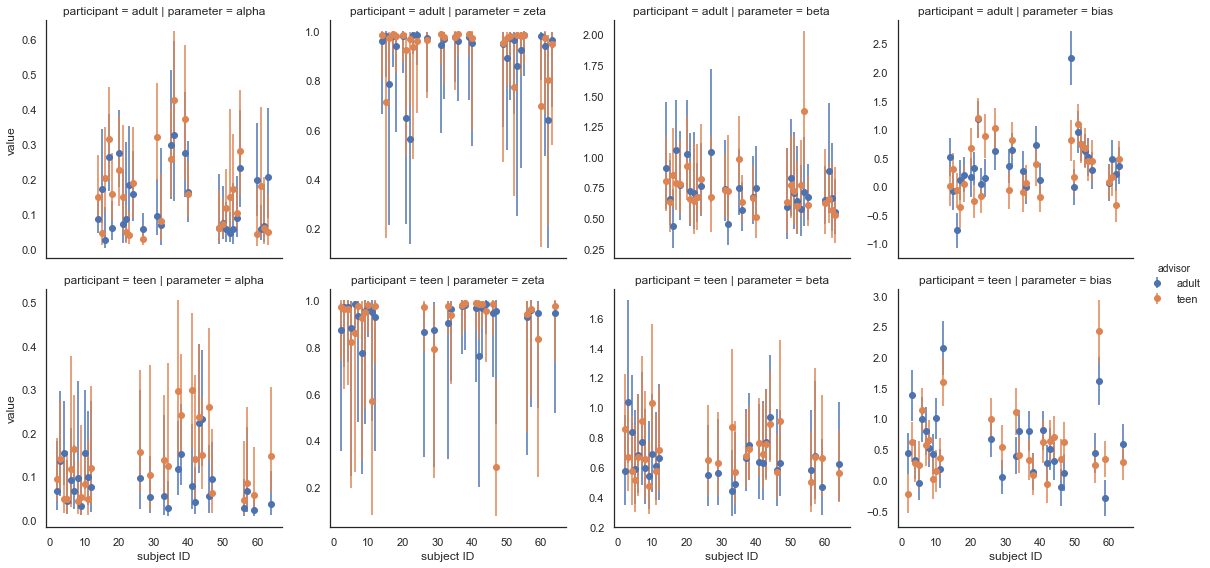

In [8]:
g = sns.FacetGrid(rl_df, col="parameter", row = 'participant', hue = 'advisor', height=4, sharey=False);
g = (g.map(errorplot, 'subject ID', 'value', 'variables')).add_legend();

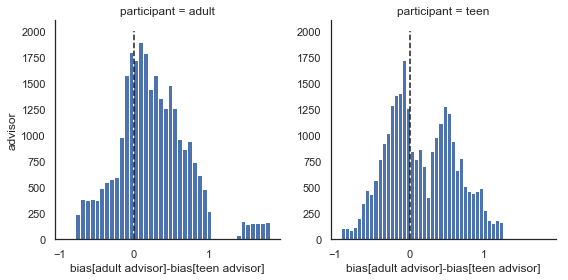

In [143]:
# Here we plot distribution over posterior estimates of bias differences between adult and teen advisors.
# A distribution with more weight above zero, suggest higher response bias for adult advisors on avarage.
# Note that the repsone bias denotes a prior preference of accepting advice.

subset1 = rl_df.loc[rl_df['parameter'] == 'bias']

def histogram(*args, **kwargs):
    sid = args[0]
    adv = args[1]
    var = args[2]
    val = args[3]
    
    adult = adv == 'adult'
    teen = adv == 'teen'
    
    up = var == '95th'
    med = var == 'median'
    low = var == '5th'
    
    sig = (val[up].values - val[low].values)/4
    sort1 = np.argsort(sid[adult & med].values)
    sort2 = np.argsort(sid[teen & med].values)
    
    diff = val[adult & med].values[sort1] - val[teen & med].values[sort2]
    sig1 = (val[adult & up].values - val[adult & low].values)/4
    sig2 = (val[teen & up].values - val[teen & low].values)/4
    sig = sig1[sort1] + sig2[sort2]
    
    sample = diff + sig*np.random.rand(1000, 1)
    
    plt.hist(sample.flatten(), bins = 40, **kwargs)
    plt.vlines(0, 0, 2000, color='k', linestyle='--')
    
g = sns.FacetGrid(subset1, col="participant", height=4, sharey=False);
g = (g.map(histogram, 'subject ID', 'advisor', 'variables', 'value'));
g.axes[0, 0].set_xlabel('bias[adult advisor]-bias[teen advisor]');
g.axes[0, 1].set_xlabel('bias[adult advisor]-bias[teen advisor]');

In [211]:
# Clustering - we will split participants (both teens and adults) in three groups based on their preference
# to accept advice from adults. If posterior sample of bias difference is grater than zero with probability
# .75 or larger, we will classify this participant as having preference for 'adult' advices. If 
# the probability is .25 or smaler, we will classify this participant as having preferences for 'teen' 
# advices. All other cases we will classify as having 'neutral' preferences. 


# Number of samples per component
n_samples = 1000

# Generate random sample, two components
def sample_bias(df, participant, n_samples):
    df_part = df.loc[df['participant'] == participant]
    adult = df_part.advisor == 'adult'
    teen = df_part.advisor == 'teen'
    
    up = df_part.variables == '95th'
    med = df_part.variables == 'median'
    low = df_part.variables == '5th'
    
    vals = df_part.value
    
    sid = df_part['subject ID']
    sort1 = np.argsort(sid[adult & med].values)
    sort2 = np.argsort(sid[teen & med].values)
    
    diff = vals[adult & med].values[sort1] - vals[teen & med].values[sort2]
    sig1 = (vals[adult & up].values - vals[adult & low].values)/4
    sig2 = (vals[teen & up].values - vals[teen & low].values)/4
    sig = sig1[sort1] + sig2[sort2]

    return diff + sig*np.random.rand(n_samples, 1)

X_adult = sample_bias(subset1, 'adult', n_samples)
X_teen = sample_bias(subset1, 'teen', n_samples) 


adult_bias = np.sum(X_adult > 0, axis = 0)/n_samples
print((adult_bias > .75).sum()/len(adult_bias))
print((adult_bias < .25).sum()/len(adult_bias))

teen_bias = np.sum(X_teen > 0, axis = 0)/n_samples
print((teen_bias > .75).sum()/len(teen_bias))
print((teen_bias > .25).sum()/len(teen_bias))

df1 = subset1.pivot(index='subjects', columns='variables', values='value')
df1['std'] = (df1['95th'] - df1['5th'])/4
df1['mean'] = df1['median']
df1 = df1.loc[:, ['mean', 'std']]

df2 = subset1.reset_index(drop=True).loc[:109, 
                                         ['subjects', 'advisor', 'participant', 'subject ID', 'session']]
df2 = df2.set_index('subjects')

result = pd.concat([df1, df2], axis=1, sort=False)
result.index.names = ['index']
result = result.sort_values('subject ID')
result = result.reset_index(drop=True)

result['preference'] = np.NaN

adult_bias = np.tile(adult_bias.reshape(1, -1), (2,1)).T.reshape(-1)
result.loc[result.participant == 'adult', 'preference'] = \
    (adult_bias > .75).astype(np.long) - (adult_bias < .25).astype(np.long)

teen_bias = np.tile(teen_bias.reshape(1, -1), (2,1)).T.reshape(-1)

result.loc[result.participant == 'teen', 'preference'] = \
    (teen_bias > .75).astype(np.long) - (teen_bias < .25).astype(np.long)

result.to_csv('bias_estimates.csv')

0.6071428571428571
0.17857142857142858
0.4444444444444444
0.5925925925925926


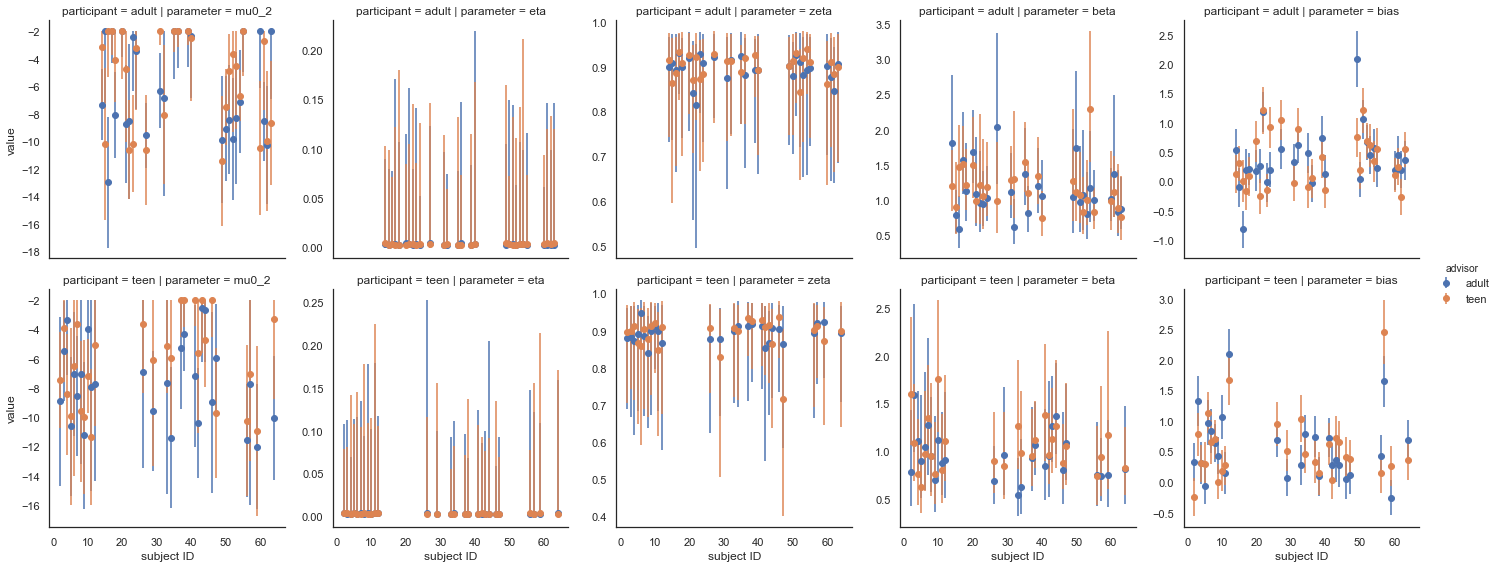

In [10]:
g = sns.FacetGrid(hgf_df, col="parameter", row = 'participant', hue = 'advisor', height=4, sharey=False);
g = (g.map(errorplot, 'subject ID', 'value', 'variables')).add_legend();

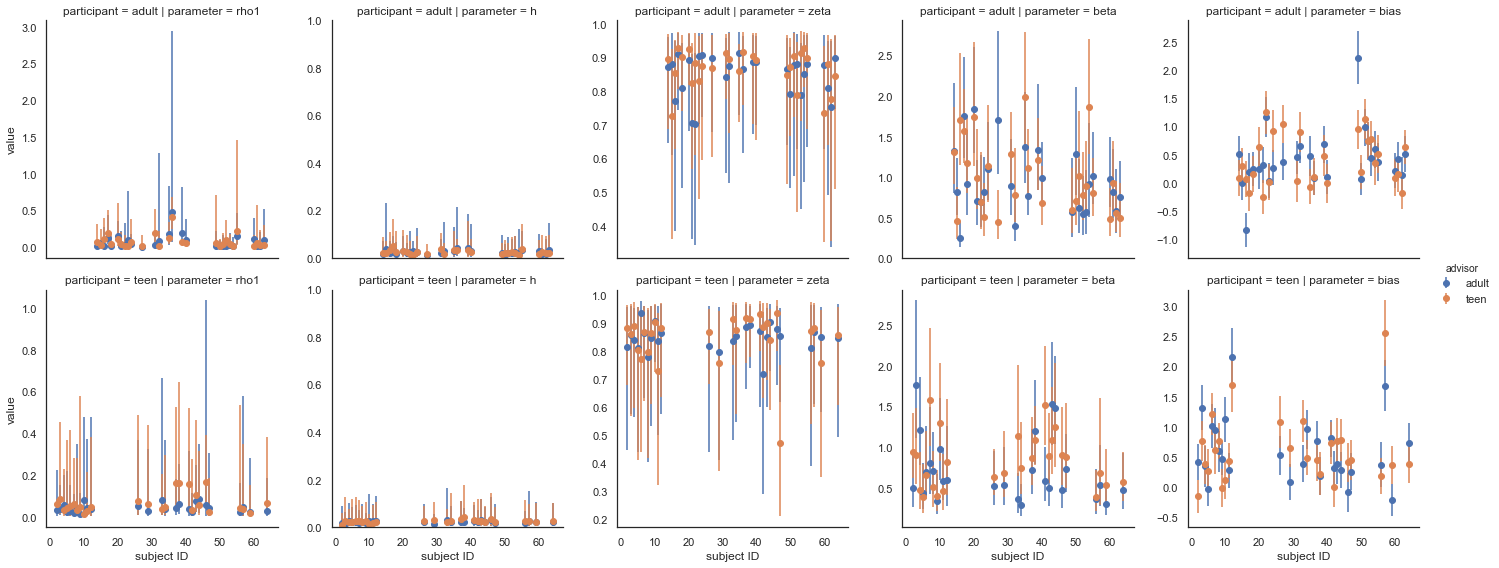

In [6]:
g = sns.FacetGrid(sgf_df, col="parameter", row = 'participant', hue = 'advisor', height=4, sharey=False);
g = (g.map(errorplot, 'subject ID', 'value', 'variables')).add_legend();
g.axes[0, 1].set_ylim([0, 1]);
g.axes[1, 1].set_ylim([0, 1]);

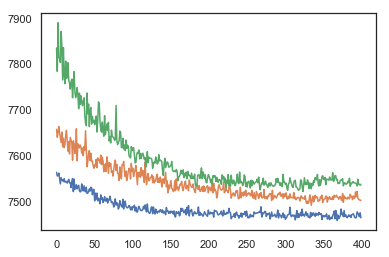

In [14]:
plt.plot(rl_infer.loss[-400:]);
plt.plot(hgf_infer.loss[-400:]);
plt.plot(sgf_infer.loss[-400:]);

In [15]:
from befit.tasks import SocialInfluence
from befit.simulate import Simulator

# format sample into parameter values
pars_rl = torch.from_numpy(sample_rl[0].values[:, :-1]).float()
pars_hgf = torch.from_numpy(sample_hgf[0].values[:, :-1]).float()
pars_sgf = torch.from_numpy(sample_sgf[0].values[:, :-1]).float()

# load stimuli (trial offers, advices, and reliability of advices)
outcomes = torch.from_numpy(np.load('advice_outcome.npy')).float()
outcomes = outcomes.reshape(trials, -1, 1).repeat(1, 1, nsub).reshape(trials, -1).unsqueeze(0)
reliability = torch.from_numpy(2.*np.load('advice_reliability.npy')-1.).float()
reliability = reliability.reshape(trials, -1, 1).repeat(1, 1, nsub).reshape(trials, -1).unsqueeze(0)
offers = torch.from_numpy(np.load('offers.npy')).reshape(trials, -1, 1).repeat(1, 1, nsub)\
            .reshape(trials, -1).unsqueeze(0)

stimuli = {'outcomes': outcomes.repeat(1, 1, n_samples), 
           'offers': offers.repeat(1, 1, n_samples), 
           'reliability': reliability.repeat(1, 1, n_samples)}

socinfl = SocialInfluence(stimuli, nsub=nsub)

runs = n_samples*2*nsub

In [16]:
# RL agent
rl_agent = RLSocInf(runs=runs, trials=trials)
rl_agent.set_parameters(pars_rl)

sim1 = Simulator(socinfl, rl_agent, runs=runs, trials=trials)
sim1.simulate_experiment();

rl_V = torch.stack(rl_agent.values[:-1]).reshape(trials, -1, 2*nsub)

In [17]:
# HGF agent
hgf_agent = HGFSocInf(runs=runs, trials=trials)
hgf_agent.set_parameters(pars_hgf)

sim2 = Simulator(socinfl, hgf_agent, runs=runs, trials=trials)
sim2.simulate_experiment();

hgf_mu = torch.stack(hgf_agent.mu[:-1]).reshape(trials, -1, 2*nsub, 2)
hgf_pi =torch.stack(hgf_agent.pi[:-1]).reshape(trials, -1, 2*nsub, 2)

In [18]:
# SGF agent
sgf_agent = SGFSocInf(runs=runs, trials=trials)
sgf_agent.set_parameters(pars_sgf)

sim3 = Simulator(socinfl, sgf_agent, runs=runs, trials=trials)
sim3.simulate_experiment();

sgf_mu = torch.stack(sgf_agent.mu)[:-1].reshape(trials, -1, 2*nsub)
sgf_sig = torch.stack(sgf_agent.sig)[:-1].reshape(trials, -1, 2*nsub)
sgf_theta = torch.stack(sgf_agent.theta)[:-1].reshape(trials, -1, 2*nsub)

In [19]:
values = io.loadmat('Conditions.mat')['subjectSubMapping']

labels = ['advisor', 'participant', 'session', 'subject ID']

vals = [
    values[:, -1],
    values[:, -2],
    values[:, -3],
    values[:, -4]
]

sess1 = torch.from_numpy(vals[-2]) == 1  # first session
adults = torch.from_numpy(vals[1]) == 10  # adult 
advisor = torch.from_numpy(vals[0]) == 1  # adult advisors
seq =  torch.ones(2*nsub, dtype=torch.uint8)  # first sequence type
seq[nsub:] = 0

def plot_trajectories(trajectories, sequence, adults, advisors, ylabel):
    titles = ['adult advisor', 'teen advisor']
    adv = [advisors, ~advisors]
    for i in range(2):
        fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
        loc1 = adv[i]*sequence*adults
        axes[0].plot(trajectories[..., loc1].median(dim=1)[0].numpy(), c='b', alpha=.1);
        axes[0].plot(trajectories[..., loc1].reshape(trials, -1).median(dim=-1)[0].numpy(), c='b', lw=3, label='adults');

        loc2 = adv[i]*sequence*(~adults)
        axes[0].plot(trajectories[..., loc2].median(dim=1)[0].numpy(), c='r', alpha=.1);
        axes[0].plot(trajectories[..., loc2].reshape(trials, -1).median(dim=-1)[0].numpy(), c='r', lw=3, label='teens');

        loc3 = adv[i]*(~sequence)*adults
        axes[1].plot(trajectories[..., loc3].median(dim=1)[0].numpy(), c='b', alpha=.1);
        axes[1].plot(trajectories[..., loc3].reshape(trials, -1).median(dim=-1)[0].numpy(), c='b', lw=3, label='adults');

        loc4 = adv[i]*(~sequence)*(~adults)
        axes[1].plot(trajectories[..., (~seq)*(~adults)*advisor].median(dim=1)[0].numpy(), c='r', alpha=.1);
        axes[1].plot(trajectories[..., (~seq)*(~adults)*advisor].reshape(trials, -1).median(dim=-1)[0].numpy(), c='r', lw=3, label='teens');

        axes[0].legend(title='participant')
        axes[0].set_ylabel(ylabel);
        axes[0].set_xlim([0, 120])
        axes[0].set_title('sequence 1');
        axes[1].set_xlim([0, 120])
        axes[1].set_title('sequence 2');

        fig.suptitle(titles[i], fontsize = 20);

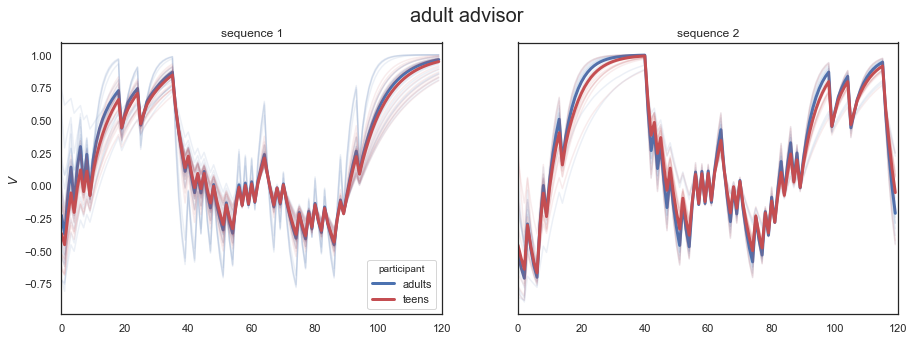

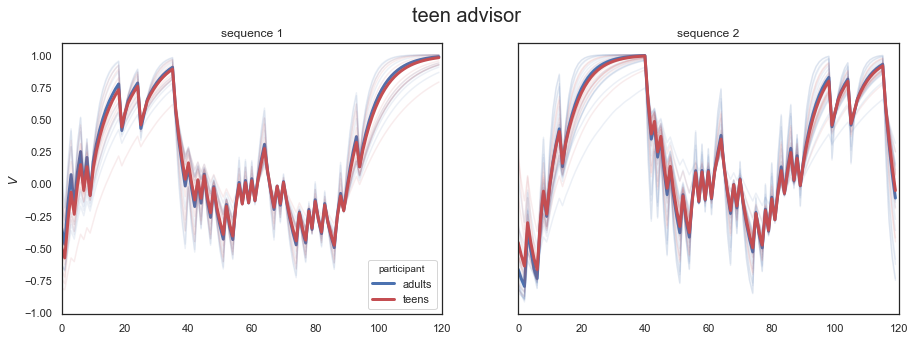

In [20]:
# plot median expectation of the RL model between sequence, advisor's age, and participant's age
plot_trajectories(rl_V, seq, adults, advisor, r'$V$')

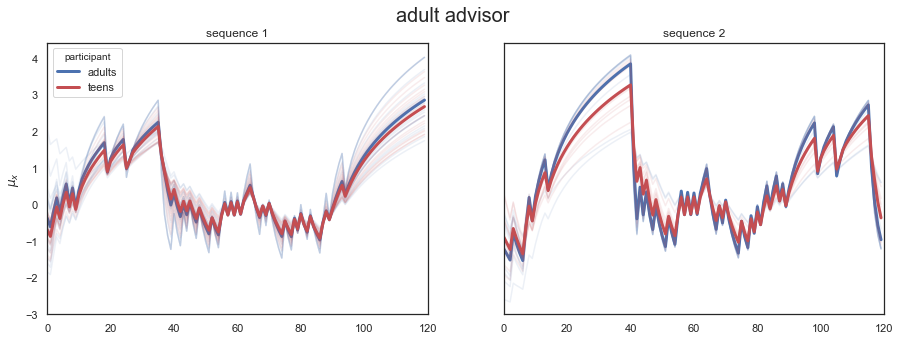

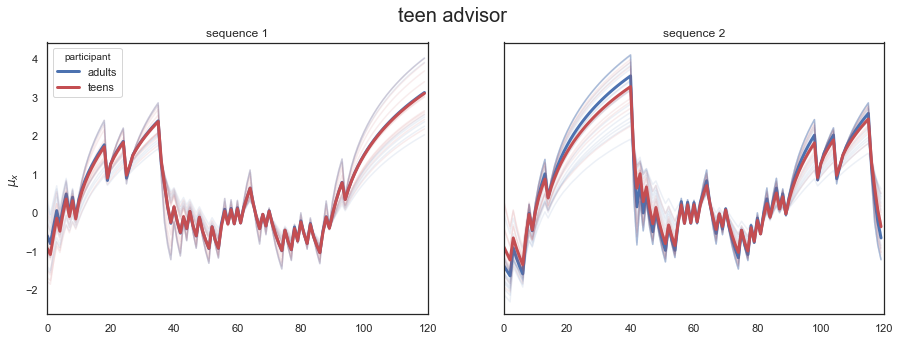

In [21]:
# plot median expectation of the HGF model between sequence, advisor's age, and participant's age
plot_trajectories(hgf_mu[..., 0], seq, adults, advisor, r'$\mu_x$')

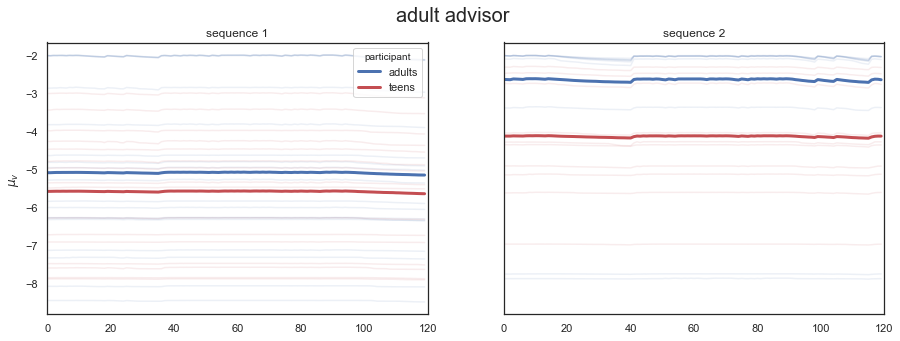

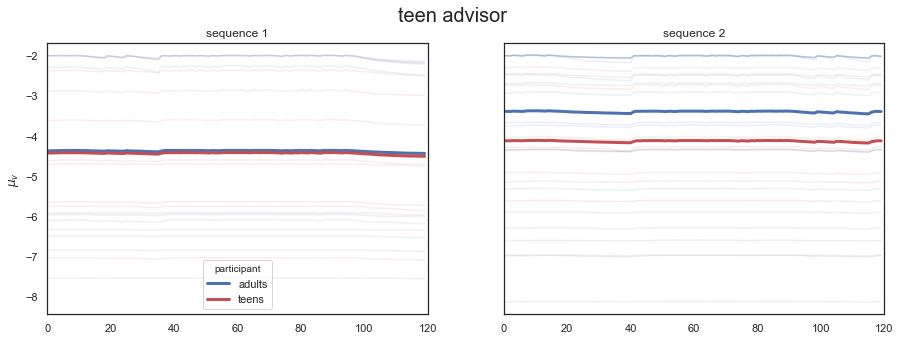

In [22]:
# plot median volatility between sequence, advisor's age, and participant's age
plot_trajectories(hgf_mu[..., 1], seq, adults, advisor, r'$\mu_v$')

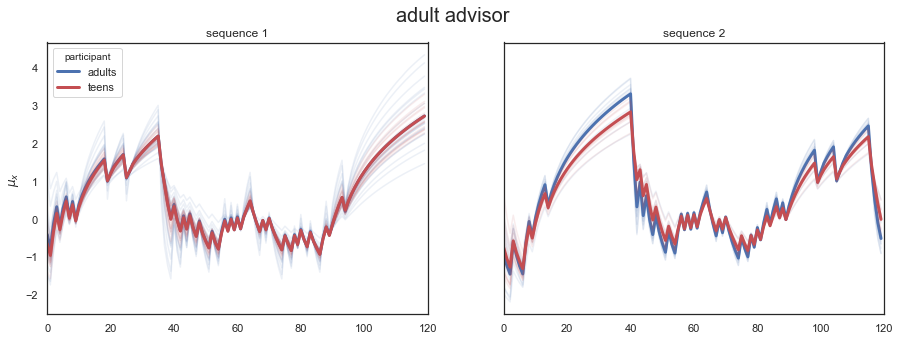

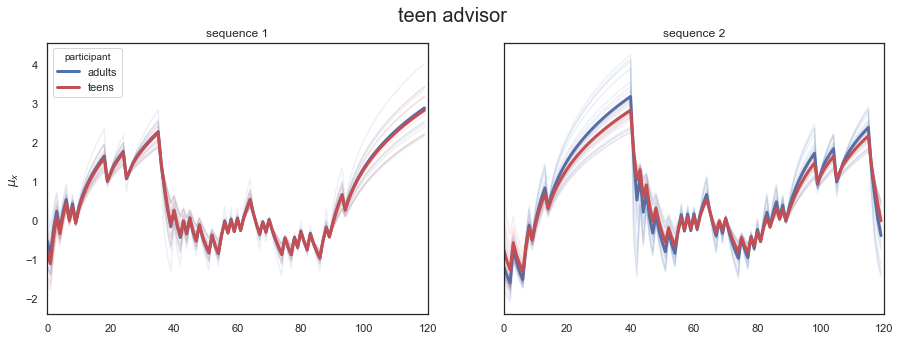

In [23]:
# plot median expectation between sequence, advisor's age, and participant's age
plot_trajectories(sgf_mu, seq, adults, advisor, r'$\mu_x$')

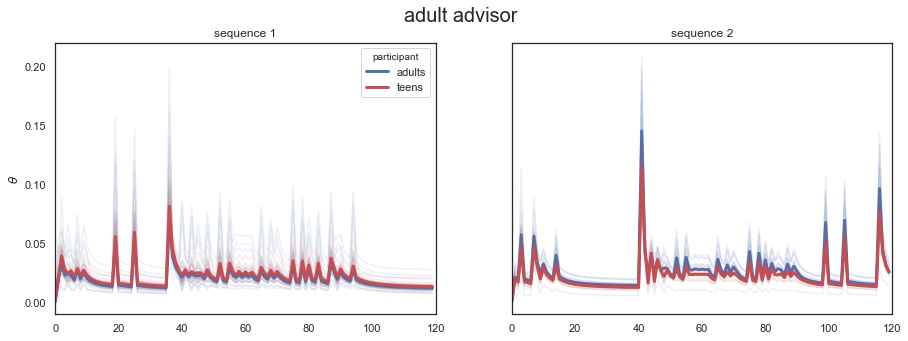

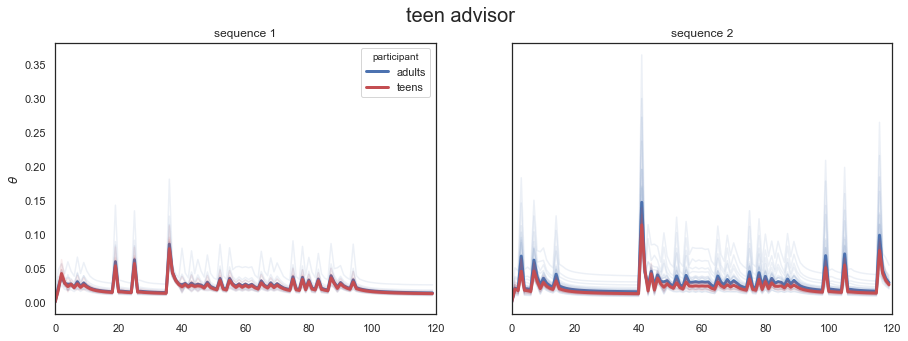

In [24]:
# plot median expectation between sequence, advisor's age, and participant's age
plot_trajectories(sgf_theta, seq, adults, advisor, r'$\theta$')